In [1]:
#import relevant libraries
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import timedelta
import sklearn
import math

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv('/Users/kasper/OneDrive/study/UvA/Master/Data mining/Assignments/Assignment 1 - advanced/dataset_mood_smartphone.csv') #load in the raw data
df = df.drop('Unnamed: 0',axis=1) #drop the unnamed column. (Still not sure how this one gets created due to the line above)
df.head()

,id,time,variable,value
0,AS14.01,2014-02-26 13:00:00.000,mood,6.0
1,AS14.01,2014-02-26 15:00:00.000,mood,6.0
2,AS14.01,2014-02-26 18:00:00.000,mood,6.0
3,AS14.01,2014-02-26 21:00:00.000,mood,7.0
4,AS14.01,2014-02-27 09:00:00.000,mood,6.0


In [7]:
df['time'] = pd.to_datetime(df['time']) #set time column to time datatype

In [8]:
df = df[(df['time'] >= '2014-03-01')] #filter out the February dates since they are only applicable for ID .01 and irrelevant
df.head()

,id,time,variable,value
7,AS14.01,2014-03-21 09:00:00,mood,6.0
8,AS14.01,2014-03-21 11:00:00,mood,6.0
9,AS14.01,2014-03-21 15:00:00,mood,7.0
10,AS14.01,2014-03-21 19:00:00,mood,6.0
11,AS14.01,2014-03-21 21:00:00,mood,6.0


In [10]:
df2 = df.set_index('time').groupby(['id', 'variable']).resample('D').mean().reset_index() #get the mean of the value per day
df2.head()

,id,variable,time,value
0,AS14.01,activity,2014-03-20,0.081548
1,AS14.01,activity,2014-03-21,0.134050
2,AS14.01,activity,2014-03-22,0.236880
3,AS14.01,activity,2014-03-23,0.142741
4,AS14.01,activity,2014-03-24,0.078961


In [11]:
pivoted = df2.pivot(index=['id', 'time'], columns='variable', values='value').reset_index() #pivot the table so that we get the variables as column and not row
pivoted.columns.name=None #formatting
pivoted = pivoted[pivoted['mood'].notna()] #filter out all rows where mood has a NaN value. Since the assignment is about mood prediction, this variable needs to be clean
pivoted.head()

,id,time,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,...,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,circumplex.arousal,circumplex.valence,mood,screen,sms
20,AS14.01,2014-03-21,0.134050,14.269173,55.095526,53.024000,6.193000,NaN,57.402,29.968875,...,70.418846,NaN,23.0290,NaN,1.0,0.2,0.2,6.20,153.665872,NaN
21,AS14.01,2014-03-22,0.236880,7.781160,51.697063,46.662000,7.025333,NaN,NaN,14.020429,...,37.305000,NaN,39.2070,NaN,1.0,0.6,0.5,6.40,47.613651,1.0
22,AS14.01,2014-03-23,0.142741,12.134396,53.442031,31.448667,10.850750,NaN,NaN,12.137167,...,NaN,NaN,30.0860,30.386,NaN,0.2,0.8,6.80,67.067644,NaN
23,AS14.01,2014-03-24,0.078961,4.982506,47.541687,122.121375,5.684333,NaN,3.010,11.093000,...,83.961000,NaN,89.3660,NaN,1.0,0.8,0.0,6.00,76.772199,NaN
24,AS14.01,2014-03-25,0.098374,10.026874,69.437507,34.103000,10.763500,NaN,NaN,29.803167,...,NaN,29.402875,22.2893,NaN,NaN,0.5,0.5,6.75,169.097283,1.0


In [12]:
days_back = 3
cols = ['activity', 'appCat.builtin', 'appCat.communication', 'appCat.entertainment', 'appCat.finance', 'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather', 'call', 'circumplex.arousal', 'circumplex.valence', 'mood', 'screen', 'sms']

df_tRange = pivoted.fillna(0) #replace all NaN values with 0.
df_tRange.head()
df_tRange = df_tRange[cols].rolling(days_back).mean()
df_tRange = df_tRange[df_tRange >= 0] #filters out values below 0
df_tRange = df_tRange.fillna(0) #replace all NaN values with 0.
df_tRange.head()

,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,circumplex.arousal,circumplex.valence,mood,screen,sms
20,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
21,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
22,0.171224,11.394910,53.411540,43.711556,8.023028,0.0,19.134000,18.708823,53.941426,35.907949,0.000000,30.774000,10.128667,0.666667,0.333333,0.500000,6.466667,89.449056,0.333333
23,0.152861,8.299354,50.893593,66.744014,7.853472,0.0,1.003333,12.416865,53.883553,40.422000,0.000000,52.886333,10.128667,0.666667,0.533333,0.433333,6.400000,63.817831,0.333333
24,0.106692,9.047925,56.807075,62.557681,9.099528,0.0,1.003333,17.677778,64.522398,27.987000,9.800958,47.247100,10.128667,0.333333,0.500000,0.433333,6.516667,104.312375,0.333333


In [13]:
final_df = df_tRange.iloc[2::3, :] #selects every 3rd row -> every 3rd day. Skipping the first two days since they don't have a rolling back value.
final_df.head()

,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,circumplex.arousal,circumplex.valence,mood,screen,sms
22,0.171224,11.394910,53.411540,43.711556,8.023028,0.000000,19.134000,18.708823,53.941426,35.907949,0.000000,30.774000,10.128667,0.666667,0.333333,0.500000,6.466667,89.449056,0.333333
25,0.092881,7.823168,54.680243,95.430935,8.389889,0.000000,1.003333,19.048611,89.210095,27.987000,9.800958,48.340100,0.000000,0.333333,0.366667,0.366667,6.450000,113.419714,0.333333
28,0.107804,37.552755,38.387778,90.311069,8.937000,38.839333,5.068083,23.880516,52.233478,33.589129,0.000000,23.824535,0.000000,1.000000,0.000000,0.800000,7.133333,105.063606,0.666667
31,0.079347,10.195603,45.433234,88.435642,7.364407,43.141000,10.265333,17.298861,52.663694,50.668757,20.842833,23.279529,0.000000,0.666667,0.000000,0.450000,6.966667,117.791254,0.000000
34,0.092615,11.933877,41.582547,64.218345,12.817409,0.000000,30.160333,19.968506,60.352649,13.895952,0.000000,15.098152,0.000000,1.000000,0.000000,0.355556,6.366667,84.916688,0.333333


In [14]:
final_df.to_csv('final_df_v2.csv')

<AxesSubplot:>

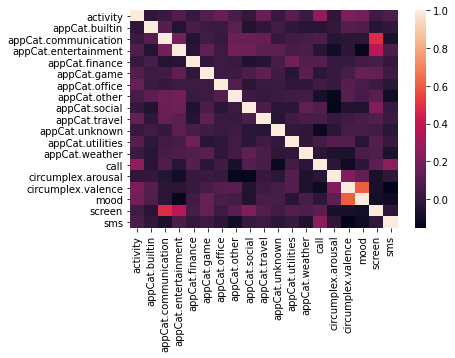

In [78]:
corr = final_df.corr()
sns.heatmap(corr)

In [79]:
X = final_df.drop(['mood', 'sms', 'screen', 'call', 'appCat.social', 'appCat.entertainment', 'appCat.communication'], axis=1)
#X = final_df['circumplex.valence']
Y = final_df['mood']
print(X.shape)
print(Y.shape)

(422, 12)
(422,)


In [80]:
#standarized the values.
scaler = MinMaxScaler().fit(X)
scaled_X = scaler.transform(X)

In [81]:
#train-test split

test_size = 0.20

X_train, X_test, Y_train, Y_test = train_test_split(scaled_X, Y, test_size = test_size, shuffle=True)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(337, 12)
(85, 12)
(337,)
(85,)


Linear: -0.344, 0.062
Lasso: -0.425, 0.1
Ridge: -0.341, 0.055
ElasticNet: -0.426, 0.12
DecisionTree: -0.47, 0.091
KNN: -0.346, 0.077
RandomForest: -0.327, 0.072
AdaBoost: -0.353, 0.068
GradientBoost: -0.324, 0.053
XGBoost: -0.3, 0.047


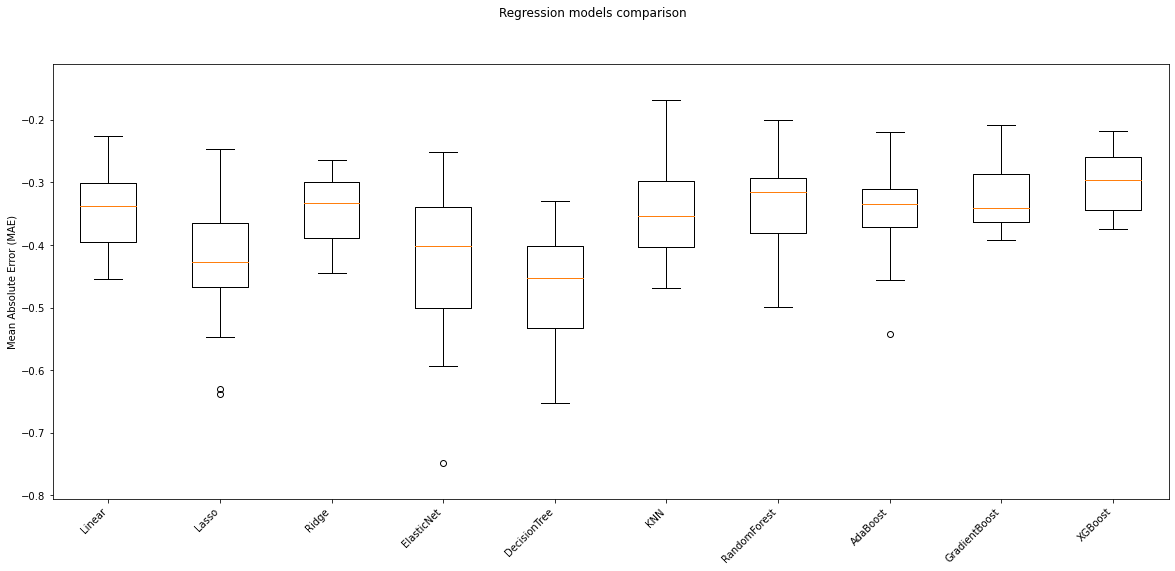

In [82]:
# user variables to tune
folds   = 20
metric  = "neg_mean_absolute_error"

# hold different regression models in a single dictionary
models = {}
models["Linear"]        = LinearRegression()
models["Lasso"]         = Lasso()
models["Ridge"]         = Ridge()
models["ElasticNet"]    = ElasticNet()
models["DecisionTree"]  = DecisionTreeRegressor()
models["KNN"]           = KNeighborsRegressor()
models["RandomForest"]  = RandomForestRegressor()
models["AdaBoost"]      = AdaBoostRegressor()
models["GradientBoost"] = GradientBoostingRegressor()
models["XGBoost"] = XGBRegressor()

# 10-fold cross validation for each model
model_results = []
model_names   = []
for model_name in models:
	model   = models[model_name]
	k_fold  = KFold(n_splits=folds, shuffle=True)
	results = cross_val_score(model, X_train, Y_train, cv=k_fold, scoring=metric)
	
	model_results.append(results)
	model_names.append(model_name)
	print("{}: {}, {}".format(model_name, round(results.mean(), 3), round(results.std(), 3)))

# box-whisker plot to compare regression models
figure = plt.figure(figsize = (20,8))

figure.suptitle('Regression models comparison')
axis = figure.add_subplot(111)
plt.boxplot(model_results)
axis.set_xticklabels(model_names, rotation = 45, ha="right")
axis.set_ylabel("Mean Absolute Error (MAE)")
plt.margins(0.05, 0.1)

In [95]:
model = GradientBoostingRegressor()
model.fit(X_train,Y_train)

#Predicting TEST & TRAIN DATA
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

error_percent = np.mean(np.abs((Y_train - train_predict) / Y_train)) * 100
print("MAPE - Mean Absolute Percentage Error (TRAIN DATA): ",error_percent )
Y_train, train_predict = np.array(Y_train), np.array(train_predict)

MAPE - Mean Absolute Percentage Error (TRAIN DATA):  2.206991446084255


In [100]:
model = GradientBoostingRegressor()
model.fit(X_test,Y_test)

#Predicting TEST & TRAIN DATA
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

    
error_percent = np.mean(np.abs((Y_test - test_predict) / Y_test)) * 100
print("MAPE - Mean Absolute Percentage Error (TEST DATA): ",error_percent )
Y_test, test_predict = np.array(Y_test), np.array(test_predict)

MAPE - Mean Absolute Percentage Error (TEST DATA):  0.6035961974322568


In [56]:
model = RandomForestRegressor()
model.fit(X_train,Y_train)

#Predicting TEST & TRAIN DATA
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

error_percent = np.mean(np.abs((Y_train - train_predict) / Y_train)) * 100
print("MAPE - Mean Absolute Percentage Error (TRAIN DATA): ",error_percent )
Y_train, train_predict = np.array(Y_train), np.array(train_predict)

MAPE - Mean Absolute Percentage Error (TRAIN DATA):  1.6734190160190052


In [86]:
model = RandomForestRegressor()
model.fit(X_test,Y_test)

#Predicting TEST & TRAIN DATA
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

    
error_percent = np.mean(np.abs((Y_test - test_predict) / Y_test)) * 100
print("MAPE - Mean Absolute Percentage Error (TEST DATA): ",error_percent )
Y_test, test_predict = np.array(Y_test), np.array(test_predict)

MAPE - Mean Absolute Percentage Error (TEST DATA):  2.2135234693667685


In [91]:
model = Lasso()
model.fit(X_test,Y_test)

#Predicting TEST & TRAIN DATA
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

    
error_percent = np.mean(np.abs((Y_test - test_predict) / Y_test)) * 100
print("MAPE - Mean Absolute Percentage Error (TEST DATA): ",error_percent )
Y_test, test_predict = np.array(Y_test), np.array(test_predict)

MAPE - Mean Absolute Percentage Error (TEST DATA):  6.3141380440838875


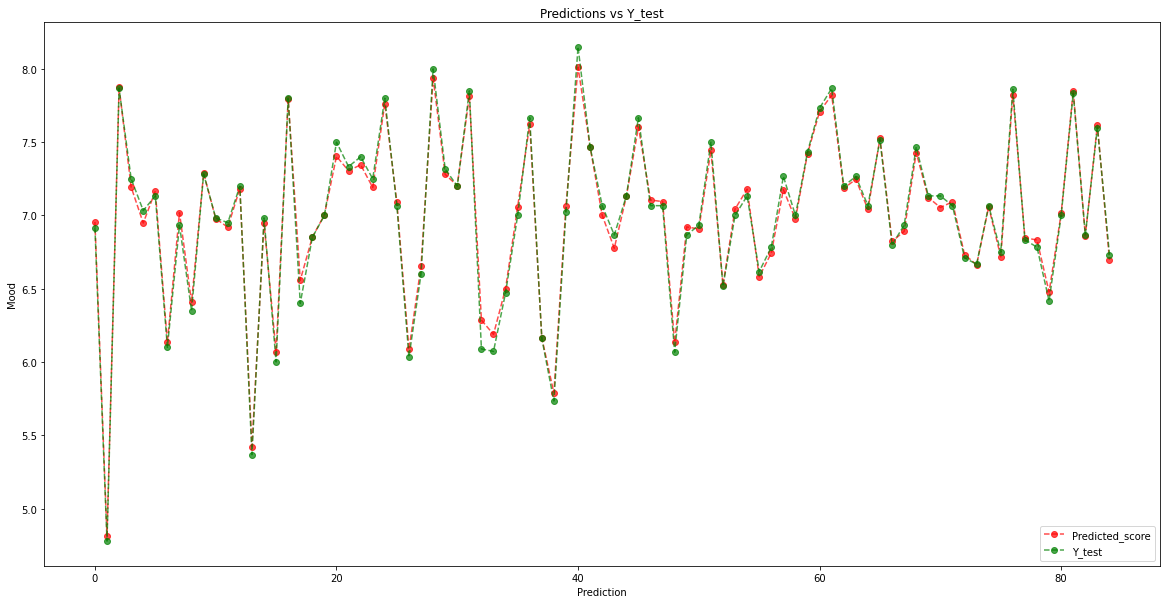

In [99]:
# plot between predictions and Y_test
x_axis = np.array(range(0, test_predict.shape[0]))
plt.figure(figsize=(20,10))
plt.plot(x_axis, test_predict, linestyle="--", marker="o", alpha=0.7, color='r', label="Predicted_score")
plt.plot(x_axis, Y_test, linestyle="--", marker="o", alpha=0.7, color='g', label="Y_test")
plt.xlabel('Prediction')
plt.ylabel('Mood')
plt.title('Predictions vs Y_test')
plt.legend(loc='lower right')